In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType
from textblob import TextBlob  # For sentiment analysis


# Create a Spark session
spark = SparkSession.builder \
    .appName("YelpUserAnalysis") \
    .getOrCreate()

24/11/24 16:45:26 WARN Utils: Your hostname, yelp resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s17)
24/11/24 16:45:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/24 16:45:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Load datasets
business_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")
review_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")
user_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_user.json")
tip_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_tip.json")

24/11/24 16:45:53 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
# Register dataframes as temporary tables for SQL queries
business_df.createOrReplaceTempView("business")
review_df.createOrReplaceTempView("reviews")
user_df.createOrReplaceTempView("users")
tip_df.createOrReplaceTempView("tips")

In [4]:
arizona_businesses_df = spark.read.parquet("file:///home/dps/Documents/temp/arizona_businesses.parquet")

In [5]:

arizona_businesses_df = arizona_businesses_df.select(
    col("business_id").alias("business_id_az"),
    "categories"
)


category_reviews_df = review_df.join(
    arizona_businesses_df,
    review_df["business_id"] == arizona_businesses_df["business_id_az"]
).filter(col("categories").contains("Mobile Phone Accessories"))

# Display the result
category_reviews_df.show(5)


+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|      business_id_az|          categories|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+--------------------+
|wdFNDQbrjjcYVytJ6...|   0|2016-10-02 00:59:25|    0|l0ZCRhOsht8Sihdvm...|  1.0|Run from here.  2...|     0|bWpk62_xsWppCDOTo...|wdFNDQbrjjcYVytJ6...|Electronics, Mobi...|
|wdFNDQbrjjcYVytJ6...|   0|2014-07-01 18:58:41|    0|s5fpIefTC2ACAFH3O...|  5.0|I go in there all...|     3|ZWdNeZECTzk44a3Bc...|wdFNDQbrjjcYVytJ6...|Electronics, Mobi...|
|44chpwVvS7tFYrOlu...|   0|2017-07-19 22:15:24|    0|8dcB_JfSf_ndLVZTQ...|  1.0|this t-mobile sto...|     0|K3iZY0pTHGsGYZpyx...|44chpwVvS7t

In [6]:
# Join reviews with user data
user_reviews_df = category_reviews_df.join(user_df, category_reviews_df.user_id == user_df.user_id)

# Display the first few rows
user_reviews_df.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+--------------------+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+--------------------+-----+---------+------------+------+--------------------+-------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|      business_id_az|          categories|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|elite|fans|             friends|funny|     name|review_count|useful|             user_id|      yelping_since|
+--------------------+----+-----

In [13]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Initialize VADER sentiment analyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Define a function to get sentiment score from review text
def get_sentiment(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']

# Create a UDF (User Defined Function) for sentiment analysis
sentiment_udf = udf(get_sentiment, DoubleType())

# Add a sentiment score column to the user reviews DataFrame
user_reviews_with_sentiment_df = user_reviews_df.withColumn("sentiment_score", sentiment_udf(user_reviews_df["text"]))

# Show the first few rows with sentiment scores
user_reviews_with_sentiment_df.show(5)
arizona_reviews_with_sentiment = user_reviews_with_sentiment_df.join(user_df, "user_id").drop(user_df["user_id"])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dps/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+--------------------+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+--------------------+-----+---------+------------+------+--------------------+-------------------+---------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|      business_id_az|          categories|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|elite|fans|             friends|funny|     name|review_count|useful|             user_id|      yelping_since|sentiment_score|


In [8]:
# Top users by review count
user_df.createOrReplaceTempView("users")
query = """
SELECT user_id, review_count
FROM users
ORDER BY review_count DESC
LIMIT 10
"""
top_users = spark.sql(query)
top_users.show()


+--------------------+------------+
|             user_id|review_count|
+--------------------+------------+
|Hi10sGSZNxQH3NLyW...|       17473|
|8k3aO-mPeyhbR5HUu...|       16978|
|hWDybu_KvYLSdEFzG...|       16567|
|RtGqdDBvvBCjcu5dU...|       12868|
|P5bUL3Engv-2z6kKo...|        9941|
|nmdkHL2JKFx55T3nq...|        8363|
|bQCHF5rn5lMI9c5kE...|        8354|
|8RcEwGrFIgkt9WQ35...|        7738|
|Xwnf20FKuikiHcSpc...|        6766|
|CxDOIDnH8gp9KXzpB...|        6679|
+--------------------+------------+



In [9]:
# Average review stars given by each user
review_df.createOrReplaceTempView("reviews")
query = """
SELECT user_id, AVG(stars) AS avg_rating
FROM reviews
GROUP BY user_id
ORDER BY avg_rating DESC
"""
avg_user_stars = spark.sql(query)
avg_user_stars.show()


+--------------------+----------+
|             user_id|avg_rating|
+--------------------+----------+
|hmbybpolwinvKxUJj...|       5.0|
|v9Wi1z2e2dA6BMdZf...|       5.0|
|JGHdJsoHZtVsr5Uy0...|       5.0|
|9izcBtnKp9iNzzPcK...|       5.0|
|PprFWJwITN1JzKkHP...|       5.0|
|E26rMqlyecLrDAfNP...|       5.0|
|GezQlM2zdWTKt6QvV...|       5.0|
|IAhBaefPlhH8rmm50...|       5.0|
|gu9gCRLNtQYuaQ2j_...|       5.0|
|ONKJJIEVIzVz9mv7t...|       5.0|
|k5o9xMkjl-B-XKWCs...|       5.0|
|tcNIu8h6CLa6_gvRc...|       5.0|
|u3J1AuKLLp19Zf47p...|       5.0|
|3bap2n0i9D0FDZq1w...|       5.0|
|xGs6PUF0varJEJ1Om...|       5.0|
|v1mQzbYqN7_xTG4KD...|       5.0|
|zCiYPZoMV_8y6H2qo...|       5.0|
|3-S_coOSnWATjpxAz...|       5.0|
|W8fpRnEkikq9OGWFs...|       5.0|
|jPF8-5j4XgiK-kuxA...|       5.0|
+--------------------+----------+
only showing top 20 rows



In [10]:
# Count of elite and non-elite users
query = """
SELECT CASE 
           WHEN elite IS NOT NULL THEN 'Elite'
           ELSE 'Non-Elite'
       END AS user_type,
       COUNT(*) AS user_count
FROM users
GROUP BY user_type
"""
elite_distribution = spark.sql(query)
elite_distribution.show()


+---------+----------+
|user_type|user_count|
+---------+----------+
|    Elite|   1987897|
+---------+----------+



In [11]:
# Users with the most tips
tip_df.createOrReplaceTempView("tips")
query = """
SELECT user_id, COUNT(*) AS tip_count
FROM tips
GROUP BY user_id
ORDER BY tip_count DESC
LIMIT 10
"""
top_tip_users = spark.sql(query)
top_tip_users.show()


+--------------------+---------+
|             user_id|tip_count|
+--------------------+---------+
|fCvMnJU1Z-XhAjKg9...|     4071|
|5Y5KbsI5buMcNh2hT...|     1385|
|lMY8NBPyzlPbbu-KB...|     1373|
|Rr4cLb6Go91FT134o...|     1230|
|qjfMBIZpQT9DDtw_B...|     1230|
|-G7Zkl1wIWBBmD0KR...|     1035|
|sraTrYU-7q_bQ0TxQ...|      902|
|I2XpWCHAom1JRyHXZ...|      821|
|xWmYN57XXZbg0LOK8...|      813|
|zYFGMy1_thjMnvQLX...|      782|
+--------------------+---------+



In [14]:
# Calculate average sentiment per user
user_sentiment_extremes = arizona_reviews_with_sentiment.groupBy("user_id").agg(
    {"sentiment_score": "avg"}
).withColumnRenamed("avg(sentiment_score)", "avg_sentiment")

# Most positive and negative users
most_positive_users = user_sentiment_extremes.orderBy("avg_sentiment(Positive)", ascending=False).limit(10)
most_negative_users = user_sentiment_extremes.orderBy("avg_sentiment(Negative)").limit(10)

most_positive_users.show()
most_negative_users.show()


+--------------------+-------------+
|             user_id|avg_sentiment|
+--------------------+-------------+
|Vbm0KbsXApDulJV0e...|       0.9969|
|-ss2d16aCoohSurXj...|       0.9966|
|5z-VdyhTsbAlH7dBT...|       0.9964|
|xEN2A1XsQO_MJyLjH...|       0.9953|
|CjnUaQwkpl0Pookvg...|       0.9944|
|MSRTOS5GyTOXY467s...|       0.9935|
|S2hrKrRH8QKh6S94K...|       0.9932|
|-3moS99nBzTULIMHb...|       0.9926|
|3cnqsAWo10ZQdmnFX...|       0.9922|
|legRu3G-rlmngzxBP...|        0.992|
+--------------------+-------------+



+--------------------+-------------+
|             user_id|avg_sentiment|
+--------------------+-------------+
|eCaaGltqGIh2BHBFq...|      -0.9929|
|PlpTYgjKDW3GEAYUs...|      -0.9913|
|DINg8XCYoGyj5a842...|        -0.99|
|_kzfxsbhhwv1A-YRH...|      -0.9887|
|7nKQbHmhry-J3cHXa...|      -0.9809|
|EiXW_b3HEhB05uo_S...|      -0.9794|
|hjijHac3G7s_-RW1S...|      -0.9759|
|Z-q__MMkZyf4R1VzA...|      -0.9657|
|3c_LCy_UwFzo6mmW0...|      -0.9638|
|iSfxsB-Yw_BdUMsoI...|      -0.9618|
+--------------------+-------------+



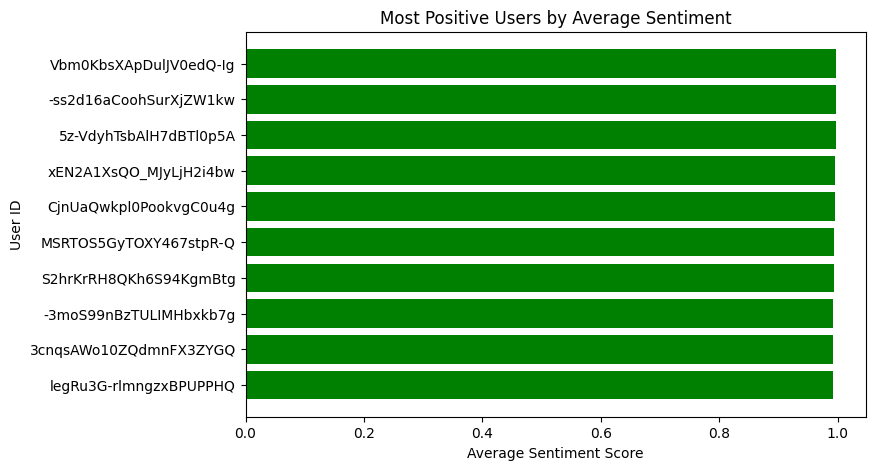

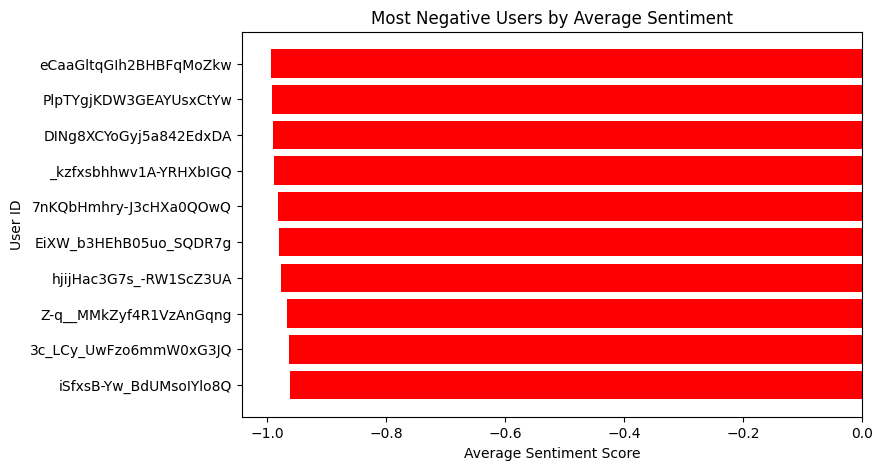

In [21]:
import matplotlib.pyplot as plt

# Convert PySpark results to Pandas DataFrames
positive_users_df = most_positive_users.toPandas()
negative_users_df = most_negative_users.toPandas()

# Plot Most Positive Users
plt.figure(figsize=(8, 5))
plt.barh(positive_users_df['user_id'], positive_users_df['avg_sentiment'], color='green')
plt.title('Most Positive Users by Average Sentiment')
plt.xlabel('Average Sentiment Score')
plt.ylabel('User ID')
plt.gca().invert_yaxis()
plt.show()

# Plot Most Negative Users
plt.figure(figsize=(8, 5))
plt.barh(negative_users_df['user_id'], negative_users_df['avg_sentiment'], color='red')
plt.title('Most Negative Users by Average Sentiment')
plt.xlabel('Average Sentiment Score')
plt.ylabel('User ID')
plt.gca().invert_yaxis()
plt.show()


In [16]:
# Average star rating and sentiment for elite users
elite_user_analysis = arizona_reviews_with_sentiment.join(
    user_df.filter(user_df["elite"].isNotNull()), "user_id"
).groupBy("user_id").agg(
    {"stars": "avg", "sentiment_score": "avg"}
).withColumnRenamed("avg(stars)", "avg_stars").withColumnRenamed(
    "avg(sentiment_score)", "avg_sentiment"
)

elite_user_analysis.show(10)


+--------------------+-------------+---------+
|             user_id|avg_sentiment|avg_stars|
+--------------------+-------------+---------+
|-72LgkpLX2wMnJG8k...|       0.5526|      1.0|
|0DTpyY1oEqc5pDDtw...|       0.8542|      5.0|
|0domlCw0vzXmEZs6M...|      -0.7249|      1.0|
|18sc4cg62GjXZ5OiQ...|       0.9915|      5.0|
|1Q9lH2nZYL6N3oRBe...|      -0.4346|      5.0|
|3RvexoG7C3sgud73B...|       0.8707|      5.0|
|3YNy3i_TUfireTTgm...|      -0.6041|      1.0|
|3c_LCy_UwFzo6mmW0...|      -0.9638|      1.0|
|45OIUuI3h3y9px-pN...|       0.6892|      5.0|
|4dmV2016Qrh68RtjO...|       0.9358|      5.0|
+--------------------+-------------+---------+
only showing top 10 rows



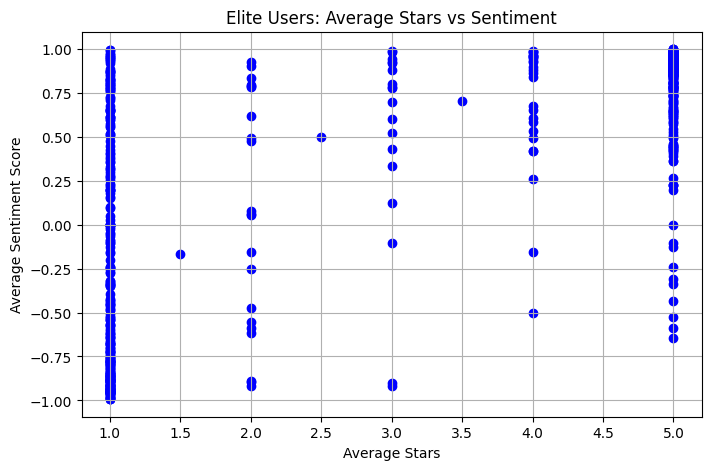

In [22]:
# Convert PySpark results to Pandas DataFrame
elite_user_analysis_df = elite_user_analysis.toPandas()

# Scatter plot for Average Stars vs Sentiment
plt.figure(figsize=(8, 5))
plt.scatter(elite_user_analysis_df['avg_stars'], elite_user_analysis_df['avg_sentiment'], color='blue')
plt.title('Elite Users: Average Stars vs Sentiment')
plt.xlabel('Average Stars')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()


In [18]:
# Join reviews with high-rated businesses
high_rated_business_reviews = review_df.filter(review_df["stars"] >= 4).join(user_df, "user_id")

# Group by user and count contributions
top_contributors_to_high_rated = high_rated_business_reviews.groupBy("user_id").count().orderBy(
    "count", ascending=False
).limit(10)

top_contributors_to_high_rated.show()


24/11/24 16:59:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 16:59:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 16:59:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 16:59:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 16:59:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 16:59:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------------------+-----+
|             user_id|count|
+--------------------+-----+
|_BcWyKQL16ndpBdgg...| 1894|
|0Igx-a1wAstiBDerG...| 1434|
|Xw7ZjaGfr0WNVt6s_...| 1423|
|ET8n-r7glWYqZhuR6...| 1280|
|wXdbkFZsfDR7utJvb...| 1261|
|bYENop4BuQepBjM1-...| 1115|
|fr1Hz2acAb3OaL3l6...| 1107|
|pou3BbKsIozfH50rx...| 1036|
|bJ5FtCtZX3ZZacz2_...| 1029|
|-G7Zkl1wIWBBmD0KR...|  999|
+--------------------+-----+



24/11/24 17:10:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 17:10:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 17:10:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 17:10:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 17:10:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 17:10:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


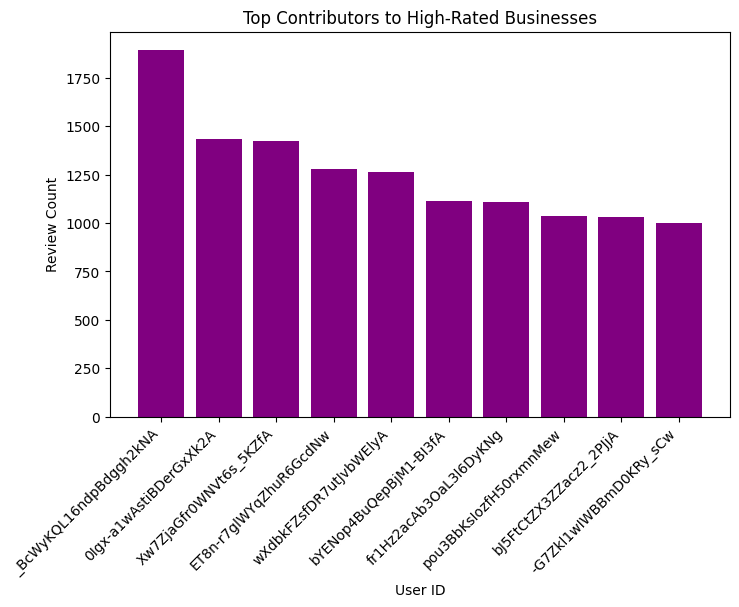

In [23]:
# Convert PySpark results to Pandas DataFrame
top_contributors_df = top_contributors_to_high_rated.toPandas()

# Bar chart for top contributors
plt.figure(figsize=(8, 5))
plt.bar(top_contributors_df['user_id'], top_contributors_df['count'], color='purple')
plt.title('Top Contributors to High-Rated Businesses')
plt.xlabel('User ID')
plt.ylabel('Review Count')
plt.xticks(rotation=45, ha='right')
plt.show()


In [19]:
# Extract year from review date
arizona_reviews = review_df.withColumn("review_year", review_df["date"].substr(1, 4))

# Group by year and user
user_contribution_trends = arizona_reviews.groupBy("user_id", "review_year").count().orderBy(
    "review_year", ascending=True
)

user_contribution_trends.show(10)


+--------------------+-----------+-----+
|             user_id|review_year|count|
+--------------------+-----------+-----+
|F4cbJPyoF1nd3S7Rq...|       2005|   11|
|X1VV7rNFaMPDIBE9P...|       2005|   13|
|3xX-Et9I4Bi4wdRPW...|       2005|   19|
|-2BsDZWzob5Q1ZGHc...|       2005|    4|
|ZftKc54UnKJSbuzyE...|       2005|    9|
|eL9CR1oxghmW8MyP5...|       2005|    2|
|y8lz_6KWGOQ9jcTyI...|       2005|    3|
|lZsusXJjzStoi3vQm...|       2005|    5|
|6-2zjWNQw117-ASTu...|       2005|    1|
|98pdN0Hn3Vx_qBlv2...|       2005|    9|
+--------------------+-----------+-----+
only showing top 10 rows



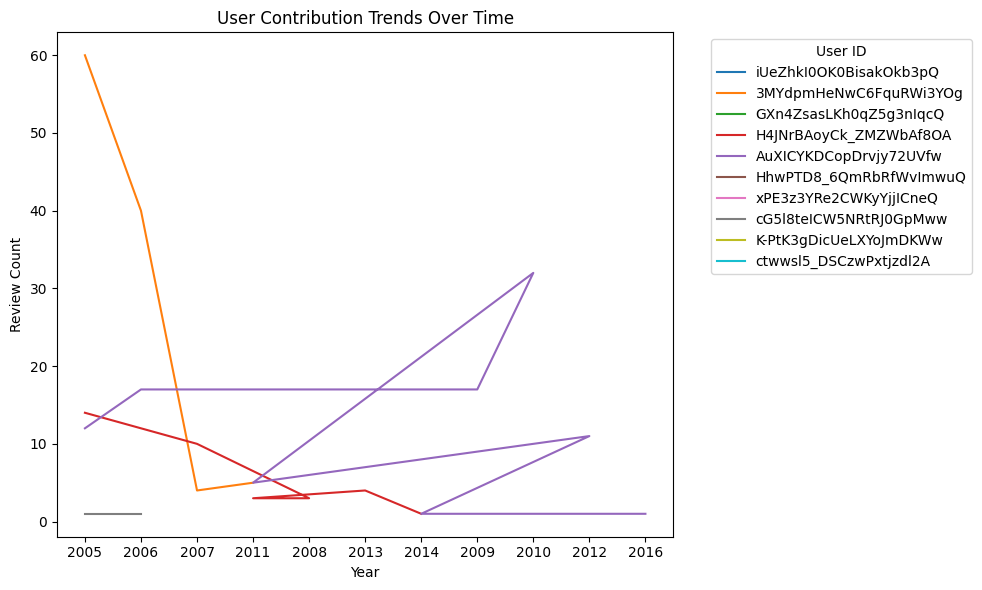

In [24]:
# Convert PySpark results to Pandas DataFrame
contribution_trends_df = user_contribution_trends.toPandas()

# Line plot for user contribution trends
plt.figure(figsize=(10, 6))
for user_id in contribution_trends_df['user_id'].unique()[:10]:  # Limit to top 10 users for clarity
    user_data = contribution_trends_df[contribution_trends_df['user_id'] == user_id]
    plt.plot(user_data['review_year'], user_data['count'], label=user_id)

plt.title('User Contribution Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Review Count')
plt.legend(title='User ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [20]:
# Calculate total useful votes per user
useful_reviews = arizona_reviews.groupBy("user_id").agg({"useful": "sum"}).withColumnRenamed(
    "sum(useful)", "total_useful_votes"
)

# Top 10 users with the most useful reviews
top_useful_users = useful_reviews.orderBy("total_useful_votes", ascending=False).limit(10)
top_useful_users.show()


+--------------------+------------------+
|             user_id|total_useful_votes|
+--------------------+------------------+
|-G7Zkl1wIWBBmD0KR...|             34694|
|ET8n-r7glWYqZhuR6...|             19474|
|vHc-UrI9yfL_pnnc6...|             17851|
|A4bsa7ykYRVCnb4h2...|             17702|
|lMY8NBPyzlPbbu-KB...|             17358|
|fr1Hz2acAb3OaL3l6...|             15356|
|tsMF0FcFcHZ8i28Wz...|             15112|
|wzUFZ3DaU7k9R2S54...|             13400|
|Xw7ZjaGfr0WNVt6s_...|             12011|
|bYENop4BuQepBjM1-...|             11680|
+--------------------+------------------+



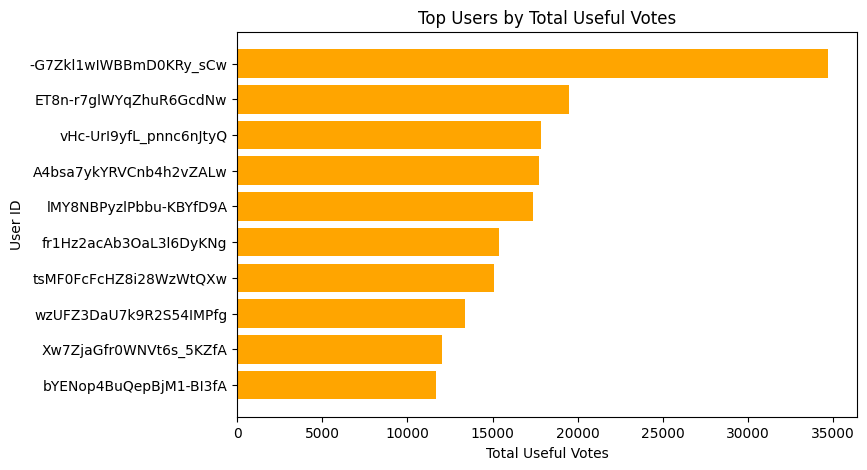

In [25]:
# Convert PySpark results to Pandas DataFrame
useful_reviews_df = top_useful_users.toPandas()

# Bar chart for most useful users
plt.figure(figsize=(8, 5))
plt.barh(useful_reviews_df['user_id'], useful_reviews_df['total_useful_votes'], color='orange')
plt.title('Top Users by Total Useful Votes')
plt.xlabel('Total Useful Votes')
plt.ylabel('User ID')
plt.gca().invert_yaxis()
plt.show()
